In [1]:
import networkx
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as st
from sklearn import preprocessing
import pickle
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../data_raw/gene_summary.tsv", sep="\t")

In [3]:
genes = data.id.values

In [4]:
G = networkx.read_edgelist(
      "../data_raw/mouse_gene_network.tsv",
      delimiter="\t",
      data=(('weight', float),),
      nodetype=str)

In [5]:
essential_genes = np.array(list(genes[:4]) + ["POLR2C", "POLR1B", "PSMC1", "PSMD4", "TH"])

In [6]:
neighbors = []
for c in essential_genes:
     neighbors += networkx.neighbors(G, c)
neighbors = np.unique(neighbors)

In [7]:
G = G.subgraph(np.sort(neighbors))

In [8]:
np.random.seed(42)
nonessential_genes = np.random.choice(list(G.nodes), size=30, replace=False)
filter_genes = np.append(essential_genes, nonessential_genes)

In [9]:
G_filtered = G.subgraph(np.sort(filter_genes))

In [10]:
essential_gene_map = {e: e for i, e in enumerate(list(G_filtered.nodes)) if e in essential_genes}

/home/simon/miniconda3/envs/ml/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


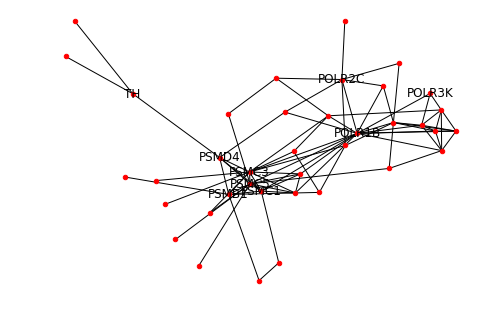

In [11]:
networkx.draw(G_filtered, node_size=20, labels=essential_gene_map);

In [12]:
cliques = [len(c) for c in networkx.clique.find_cliques(G_filtered)]

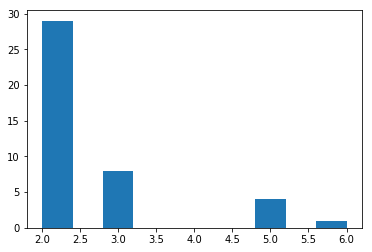

In [13]:
plt.hist(cliques);

## Data generation small

In [14]:
gamma_tau = .25
gamma_tau_non_essential = .1

In [15]:
np.random.seed(1)
n_essential = 1
n_nonessential = 1
n_genes = n_essential + n_nonessential

gamma_essential = sp.random.normal(-1, scale=gamma_tau, size=n_essential)
gamma_nonessential = sp.random.normal(0, scale=gamma_tau_non_essential, size=n_nonessential)
gamma = sp.append(gamma_essential, gamma_nonessential)

In [16]:
gamma_essential

array([-0.59391366])

In [17]:
gamma_nonessential

array([-0.06117564])

In [18]:
n_conditions, n_sgrnas, n_replicates = 5, 5, 5

In [19]:
genes = essential_genes[:2]

In [20]:
conditions = ["C" + str(i) for i in range(n_conditions)]
sgrnas = ["S" + str(i) for i in range(n_sgrnas)]
replicates = ["R" + str(i) for i in range(n_replicates)]

In [21]:
combinations = [(g, c, s, r) \
     for g in genes for c in conditions \
     for s in sgrnas for r in replicates]

In [24]:
count_table = pd.DataFrame(
    combinations, columns=["genes", "conditions", "sgrnas", "replicates"])

In [26]:
count_table.shape

(250, 4)

In [27]:
sgrna_ids = np.repeat(["S" + str(i) \
                       for i in range(n_conditions * n_sgrnas * n_genes)], 
                      n_replicates)
count_table.sgrnas = sgrna_ids
condition_ids = np.repeat(["C" + str(i) \
                           for i in range(n_genes * n_conditions)],
                          n_sgrnas * n_replicates)
count_table.conditions = condition_ids

In [28]:
le = preprocessing.LabelEncoder()
for i in count_table.columns.values:
    count_table[i] = le.fit_transform(count_table[i])

In [29]:
beta_tau = .25
l_tau = .25

In [31]:
beta = st.norm.rvs(np.repeat(gamma, n_conditions), beta_tau)
l = st.norm.rvs(0, l_tau, size = n_conditions * n_genes * n_sgrnas)

In [32]:
data_tau = .25
data = st.norm.rvs(
    l[count_table["sgrnas"]] + beta[count_table["conditions"]],
    data_tau)

In [33]:
count_table = pd.DataFrame(
    combinations, 
    columns=["gene", "condition", "intervention", "replicate"])

count_table["gamma"] = np.repeat(gamma, count_table.shape[0] / len(gamma))
count_table["beta"] = np.repeat(beta, count_table.shape[0] / len(beta))
count_table["l"] = np.repeat(l, count_table.shape[0] / len(l))
count_table["readout"] = data

sgrna_ids = np.repeat(["S" + str(i) for i in range(n_conditions * n_sgrnas * n_genes)], 
                      n_replicates)
count_table.intervention = sgrna_ids

In [34]:
count_table

,gene,condition,intervention,replicate,gamma,beta,l,readout
0,PSMC5,C0,S0,R0,-0.593914,-0.465681,0.040009,-0.107233
1,PSMC5,C0,S0,R1,-0.593914,-0.465681,0.040009,0.066104
2,PSMC5,C0,S0,R2,-0.593914,-0.465681,0.040009,-0.890167
3,PSMC5,C0,S0,R3,-0.593914,-0.465681,0.040009,-0.116631
4,PSMC5,C0,S0,R4,-0.593914,-0.465681,0.040009,-0.018759
5,PSMC5,C0,S1,R0,-0.593914,-0.465681,0.219042,-0.162136
6,PSMC5,C0,S1,R1,-0.593914,-0.465681,0.219042,-0.546456
7,PSMC5,C0,S1,R2,-0.593914,-0.465681,0.219042,-0.030803
8,PSMC5,C0,S1,R3,-0.593914,-0.465681,0.219042,-0.291869
9,PSMC5,C0,S1,R4,-0.593914,-0.465681,0.219042,-0.397619


In [35]:
count_table.to_csv("../data_raw/easy_simulated_data/small-simulated_data.tsv", index=False, sep="\t")

In [36]:
G_filtered_small = G_filtered.subgraph(genes)

In [37]:
networkx.readwrite.edgelist.write_weighted_edgelist(
    G_filtered_small, "../data_raw/easy_simulated_data/small-graph.tsv", delimiter="\t")

In [39]:
data = {    
    "graph": G_filtered_small,
    "essential_genes": essential_genes,
    "nonessential_genes": nonessential_genes,    
    "gamma_tau": gamma_tau,
    "gamma_tau_non_essential": gamma_tau_non_essential,
    "gamma_essential": gamma_essential,
    "gamma_nonessential": gamma_nonessential,
    "gamma": gamma,
    "beta_tau": beta_tau,    
    "beta": beta,
    "l_tau": l_tau,
    "l": l,
    "data_tau": data_tau,
    "data": data,
    "count_table": count_table
}

In [40]:
with open("../data_raw/easy_simulated_data/small-data.pickle","wb") as out:
    pickle.dump(data, out)

## Data generation big

In [35]:
gamma_tau = .25
gamma_tau_non_essential = .1

In [36]:
np.random.seed(1)
n_essential = len(essential_genes)
n_nonessential = len(nonessential_genes)
n_genes = n_essential + n_nonessential

gamma_essential = sp.random.normal(-1, scale=gamma_tau, size=n_essential)
gamma_nonessential = sp.random.normal(0, scale=gamma_tau_non_essential, size=n_nonessential)
gamma = sp.append(gamma_essential, gamma_nonessential)

In [37]:
gamma_essential

array([-0.59391366, -1.1529391 , -1.13204294, -1.26824216, -0.78364809,
       -1.57538467, -0.56379706, -1.19030173, -0.92024023])

In [38]:
gamma_nonessential

array([-0.02493704,  0.14621079, -0.20601407, -0.03224172, -0.03840544,
        0.11337694, -0.10998913, -0.01724282, -0.08778584,  0.00422137,
        0.05828152, -0.11006192,  0.11447237,  0.09015907,  0.05024943,
        0.09008559, -0.06837279, -0.01228902, -0.09357694, -0.02678881,
        0.05303555, -0.06916608, -0.03967535, -0.06871727, -0.08452056,
       -0.06712461, -0.00126646, -0.11173103,  0.02344157,  0.16598022])

In [39]:
sp.log2(
    st.norm.pdf(gamma_essential, -1, gamma_tau) /  \
    st.norm.pdf(gamma_essential, 0, gamma_tau_non_essential)
)

array([ 22.21913685,  94.29456969,  90.91905589, 113.87190038,
        42.43609664, 173.88372347,  19.41129068, 100.46192656,
        59.69139186])

In [40]:
sp.log2(
    st.norm.pdf(gamma_nonessential, -1, gamma_tau) /  \
    st.norm.pdf(gamma_nonessential, 0, gamma_tau_non_essential)
)

array([-12.25018355, -14.94315303,  -5.5363568 , -12.05626055,
       -11.88759753, -14.70169713,  -9.59156346, -12.44745505,
       -10.37016466, -12.95985115, -14.00298875,  -9.58891265,
       -14.71185941, -14.45209981, -13.87040402, -14.45120622,
       -11.00196781, -12.57066864, -10.17284752, -12.20163502,
       -13.91727968, -10.97704501, -11.85227569, -10.99115451,
       -10.4796289 , -11.04102731, -12.83415739,  -9.52795271,
       -13.37129661, -15.02552176])

In [41]:
n_conditions, n_sgrnas, n_replicates = 4, 5, 5

In [42]:
genes = filter_genes
conditions = ["C" + str(i) for i in range(n_conditions)]
sgrnas = ["S" + str(i) for i in range(n_sgrnas)]
replicates = ["R" + str(i) for i in range(n_replicates)]

In [43]:
combinations = [(g, c, s, r) \
     for g in genes for c in conditions \
     for s in sgrnas for r in replicates]

In [44]:
count_table = pd.DataFrame(
    combinations, columns=["genes", "conditions", "sgrnas", "replicates"])

In [45]:
sgrna_ids = np.repeat(["S" + str(i) \
                       for i in range(n_conditions * n_sgrnas * n_genes)], 
                      n_replicates)
count_table.sgrnas = sgrna_ids
condition_ids = np.repeat(["C" + str(i) \
                           for i in range(n_genes * n_conditions)],
                          n_sgrnas * n_replicates)
count_table.conditions = condition_ids

In [46]:
le = preprocessing.LabelEncoder()
for i in count_table.columns.values:
    count_table[i] = le.fit_transform(count_table[i])

In [47]:
beta_tau = .25
l_tau = .25
beta = st.norm.rvs(np.repeat(gamma, n_conditions), beta_tau)
l = st.norm.rvs(0, l_tau, size = n_conditions * n_genes * n_sgrnas)

In [48]:
data_tau = .25
data = st.norm.rvs(
    l[count_table["sgrnas"]] + beta[count_table["conditions"]],
    data_tau)

In [49]:
count_table = pd.DataFrame(
    combinations, 
    columns=["gene", "condition", "intervention", "replicate"])

count_table["gamma"] = np.repeat(gamma, count_table.shape[0] / len(gamma))
count_table["beta"] = np.repeat(beta, count_table.shape[0] / len(beta))
count_table["l"] = np.repeat(l, count_table.shape[0] / len(l))
count_table["readout"] = data

sgrna_ids = np.repeat(["S" + str(i) for i in range(n_conditions * n_sgrnas * n_genes)], 
                      n_replicates)
count_table.intervention = sgrna_ids

In [50]:
count_table

,gene,condition,intervention,replicates,gamma,beta,l,readout
0,PSMC5,C0,S0,R0,-0.593914,-0.408403,-0.406860,-0.736103
1,PSMC5,C0,S0,R1,-0.593914,-0.408403,-0.406860,-1.481294
2,PSMC5,C0,S0,R2,-0.593914,-0.408403,-0.406860,-0.921869
3,PSMC5,C0,S0,R3,-0.593914,-0.408403,-0.406860,-0.716815
4,PSMC5,C0,S0,R4,-0.593914,-0.408403,-0.406860,-0.872297
5,PSMC5,C0,S1,R0,-0.593914,-0.408403,0.150580,-0.112740
6,PSMC5,C0,S1,R1,-0.593914,-0.408403,0.150580,-0.501140
7,PSMC5,C0,S1,R2,-0.593914,-0.408403,0.150580,-0.214031
8,PSMC5,C0,S1,R3,-0.593914,-0.408403,0.150580,-0.271194
9,PSMC5,C0,S1,R4,-0.593914,-0.408403,0.150580,-0.303588


In [51]:
count_table.to_csv("../data_raw/easy_simulated_data/simulated_data.tsv", index=False, sep="\t")

In [52]:
networkx.readwrite.edgelist.write_weighted_edgelist(
    G_filtered, "../data_raw/easy_simulated_data/graph.tsv", delimiter="\t")

In [53]:
data = {    
    "graph": G_filtered,
    "essential_genes": essential_genes,
    "nonessential_genes": nonessential_genes,    
    "gamma_tau": gamma_tau,
    "gamma_tau_non_essential": gamma_tau_non_essential,
    "gamma_essential": gamma_essential,
    "gamma_nonessential": gamma_nonessential,    
    "beta_tau": beta_tau,    
    "beta": beta,
    "l_tau": l_tau,
    "l": l,
    "data_tau": data_tau,
    "data": data,
    "count_table": count_table
}

In [54]:
with open("../data_raw/easy_simulated_data/data.pickle","wb") as out:
    pickle.dump(data, out)